In [ ]:

import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
#from keras.layers.normalization import BatchNormalization
from tensorflow.keras.layers import BatchNormalization
import os
import seaborn as sns
from keras.applications.mobilenet import MobileNet
import pandas as pd

from keras.applications.vgg16 import VGG16
import tracemalloc
import time

In [ ]:
begin=time.time()
# starting the monitoring
tracemalloc.start()

In [ ]:
import cv2
import os
import glob
import gc

def read_images(img_dir, xdim, ydim, nmax=5000) :
    """ 
   Read images from subdirectories of img_dir
    nmax images read in each directory at most
    Returns:
    X : list of images read, xdim*ydim matrices
    y : list of digital labels
    label : label name
    label_names : list of names of directories read
    """
    label = 0
    label_names = []
    X = []
    y=[]
    for dirname in os.listdir(img_dir):
        print(dirname)
        label_names.append(dirname)
        data_path = os.path.join(img_dir + "/" + dirname,'*g')
        files = glob.glob(data_path)
        n=0
        for f1 in files:
            if n>nmax : break
            img = cv2.imread(f1) # Reading image from directory
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Conversion couleur RGB
            img = cv2.resize(img, (xdim,ydim)) # Image resizing

            X.append(np.array(img)) # Convert to table and add to image list
            y.append(label) # Added image tag to tag list
            n=n+1
        print(n,' images read')
        label = label+1
    X = np.array(X)
    y = np.array(y)
    gc.collect() # Memory recovery
    return X,y, label, label_names


In [ ]:
X,y,Nombre_classes,Classes = read_images("chest_xray/train", 224, 224, 5216 )

NORMAL
1341  images read
PNEUMONIA
3875  images read


In [ ]:
#Create a function to calculate the files in a directory
def calculate_files(x):
    return (len([name for name in os.listdir(x)]))

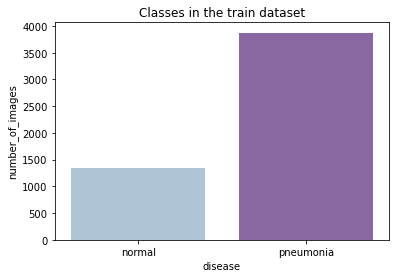

In [ ]:
#Assign links to each folder to variables
train_normal = calculate_files('chest_xray/train/NORMAL')
train_pneumonia = calculate_files('chest_xray/train/PNEUMONIA')
test_normal = calculate_files('chest_xray/test/NORMAL')
test_pneumonia = calculate_files('chest_xray/test/PNEUMONIA')

#Create a dataframe with count of each class in the train dataset
train_barplot = pd.DataFrame({'number_of_images':[train_normal,train_pneumonia], 'disease':['normal', 'pneumonia']})
#display(train_barplot)
#Plot classes of the train dataset
import seaborn as sns
sns.barplot(y = 'number_of_images', x = 'disease', 
            data = train_barplot,
            palette=("BuPu")).set_title('Classes in the train dataset');

,number_of_images,disease
0,234,normal
1,390,pneumonia


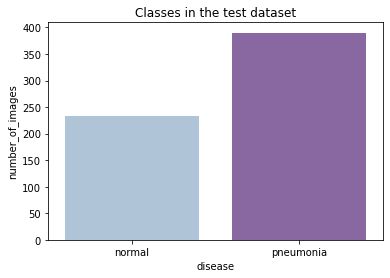

In [ ]:
#Create a dataframe with count of each class in the test dataset 
test_barplot = pd.DataFrame({'number_of_images':[test_normal,test_pneumonia], 'disease':['normal', 'pneumonia']})
display(test_barplot)
#Plot classes of the test dataset
sns.barplot(y = 'number_of_images', x = 'disease', 
            data = test_barplot,
            palette=("BuPu")).set_title('Classes in the test dataset');

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

In [ ]:

# Normalize pixel values to between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0 


In [ ]:
SIZE = 224  #Resize images

#Load model wothout classifier/fully connected layers
MobileNet_model = MobileNet(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))

#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in MobileNet_model.layers:
	layer.trainable = False

In [ ]:
MobileNet_model.summary()  #Trainable parameters will be 0


Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 14, 14, 512)      4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_pw_9 (Conv2D)          (None, 14, 14, 512)       262144    
                                                                 
 conv_pw_9

In [ ]:
#Now, let us use features from convolutional network for RF
feature_extractor=MobileNet_model.predict(x_train)

features = feature_extractor.reshape(feature_extractor.shape[0], -1 )

X_for_training = features #This is our X input to RF


In [ ]:

#RANDOM FOREST
#from sklearn.ensemble import RandomForestClassifier
#Rf_model = RandomForestClassifier(n_estimators = 50, random_state = 42)


In [ ]:
# Train the model on training data
#Rf_model.fit(X_for_training, y_train)
#
!pip install xgboost


In [ ]:
#XGBOOST
import xgboost as xgb
Rf_model = xgb.XGBClassifier()
Rf_model.fit(X_for_training, y_train) #For sklearn no one hot encoding


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [ ]:
#Send test data through same feature extractor process
X_test_feature = MobileNet_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)


In [ ]:

#Now predict using the trained RF model. 
prediction = Rf_model.predict(X_test_features) 

In [ ]:
#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(y_test, prediction))

Accuracy =  0.975095785440613


In [ ]:

#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, prediction)

tp, fp, fn ,tn = cm.ravel()
print("confusion_matrix===========")
print(cm)
print("\ntest_matrix==============")
precision=tp/(tp+fp)*100
recall=tp/(tp+fn)*100
sensitivity=tn/(tn+fp)
#print('accuracy: {}%'.format(acc))
print('precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-scor: {}%'.format(2*precision*recall/(precision+recall)))

#sns.heatmap(cm, annot=True)

confusion_matrix===========
[[117   8]
 [  5 392]]

test_matrix==============
precision: 93.60000000000001%
Recall: 95.90163934426229%
F1-scor: 94.73684210526316%


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,prediction,target_names=['Normal','Pneumonia']))

              precision    recall  f1-score   support

      Normal       0.96      0.94      0.95       125
   Pneumonia       0.98      0.99      0.98       397

    accuracy                           0.98       522
   macro avg       0.97      0.96      0.97       522
weighted avg       0.97      0.98      0.97       522



<Figure size 432x288 with 0 Axes>

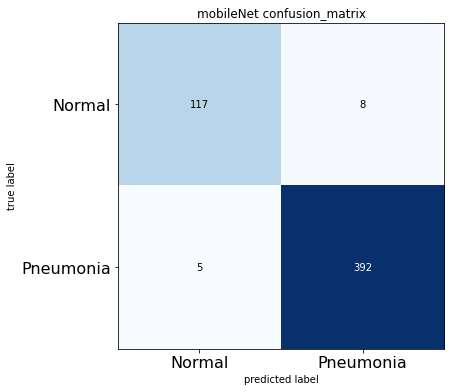

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
plt.figure()

plot_confusion_matrix(cm, figsize=(8,6),hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(2),['Normal','Pneumonia'],fontsize=16)
plt.yticks(range(2),['Normal','Pneumonia'],fontsize=16)
plt.title("mobileNet confusion_matrix")

plt.show()


The prediction for this image is:  0
The actual label for this image is:  0


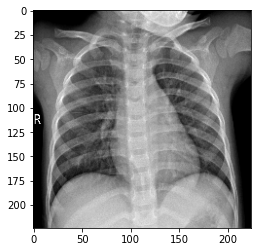

In [ ]:

#Check results on a few select images
n=np.random.randint(0, x_test.shape[0])
img = x_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_feature=MobileNet_model.predict(input_img)
input_img_features=input_img_feature.reshape(input_img_feature.shape[0], -1)
prediction = Rf_model.predict(input_img_features)[0] 
#prediction = le.inverse_transform([prediction])  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction)
print("The actual label for this image is: ", y_test[n])

In [ ]:
end=time.time()
total_time=end-begin
# displaying the time taken
print(total_time)

# displaying the memory
print(tracemalloc.get_traced_memory())
 
# stopping the library
tracemalloc.stop()

223.57241415977478
(10968257362, 11277720358)


In [ ]:
# allow user to upload the image to predict
from google.colab import files
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input


uploaded = files.upload()

for fn in uploaded.keys():
  # predict images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(224,224))
  x1 = image.img_to_array(img)
  x1 = np.expand_dims(x1, axis =0)
  img_data=preprocess_input(x1)
  #images = np.vstack([x])
  classes = Rf_model.predict(img_data, batch_size = 32)
  result=int(classes[0][0])
  if result==1:
      print("Person is Affected By PNEUMONIA")
      plt.imshow(img)
  else:
     print("Result is Normal")
     plt.imshow(img)


ModuleNotFoundError: No module named 'google.colab'